# Building a regression model for predicting house sale prices

In [259]:
import pickle
import pathlib
import numpy as np
import pandas as pd

In [260]:
import warnings
warnings.filterwarnings('ignore')

In [261]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

/home/andre/Desktop/MachineLearning/ames_AndreVictor/data


In [262]:
clean_data_path = DATA_DIR / 'processed' / 'ames_transformed.pkl'

In [263]:
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2872 non-null   category
 1   MS.Zoning        2872 non-null   category
 2   Lot.Frontage     2872 non-null   float64 
 3   Lot.Area         2872 non-null   float64 
 4   Lot.Shape        2872 non-null   category
 5   Land.Contour     2872 non-null   category
 6   Lot.Config       2872 non-null   category
 7   Land.Slope       2872 non-null   category
 8   Neighborhood     2872 non-null   category
 9   Bldg.Type        2872 non-null   category
 10  House.Style      2872 non-null   category
 11  Overall.Qual     2872 non-null   category
 12  Overall.Cond     2872 non-null   category
 13  Roof.Style       2872 non-null   category
 14  Mas.Vnr.Type     2872 non-null   category
 15  Mas.Vnr.Area     2872 non-null   float64 
 16  Exter.Qual       2872 non-null   category


In [265]:
model_data = data.copy()

## Preparing the data for the model

Now that we have the data all cleaned, and all the missing values accounted for, lets focus on transforming the data for the model.

Lets remember what a model is. 

- A predictive model is a **set** of functions that receive data as input and produce a prediction, that is, an estimate of the target value as output.
- **Train** a model is to search the set of candidate functions for one that adequately represents the **training dataset**.
- The adequacy of a candidate function to the training data is usually determined by a **loss function** that measures how well the predictions of the function match the real values of the target within the training dataset. It is common to define a *loss function per data item* (e.g. absolute error, quadratic error, etc) and to construct the *loss function over the dataset* as the *average prediction loss*.

Many models are **parametric models**. In this case, each function of the set of functions that makes the model is constructed from a vector of **parameters** that define the function, forming a **parametric function**. For instance: the linear model constructs prediction values out of a linear combination of the input features, plus a constant. The weights of the linear combination plus the constant are the parameters of the model. The set of functions that can be represented by this model is given by all possible values of the vector of parameters that define the function.

Some models are called **non-parametric models**. These models usually do not have a parametric form (like the linear model). But the terminology is a bit misleading, though: usually these models *do* have parameters, and potentially an open-ended set of them! For instance, consider the "decision tree" model, which is one of the most prominent models of this category. The decision tree may not have a formula for the predicted value, but it does have parameters, many of them: each decision in the tree involves a choice of feature and a threshold level, and those choices must be stored as parameters of the model for use in future predictions.

Each model has specific requirements for the format of the input data. Most of the time, the minimum requirement is that:

- All columns are numeric;
- There are no missing values.

Some models have extra requirements. For example: the support-vector-machines model requires that the input features have comparable standard deviations - having features that have large discrepancies between features in terms of their order of magnitude (such as a feature in the fractions of unit range and another in the tens of thousands) will result in poor prediction quality.

And some models may not have any special requirement at all. We will study each of those in detail in this course.

Lets start our study with a simple model: the *multivariate linear regression* model. This is a model that presents the minimum requirements listed above. So we need to do a bit of processing on the original features:

- *Numerical features* stay as given;
- *Categorical features* have to be transformed into numerical features. In order to do so we need to **encode** these features, that is: to transform them into new features that convey the same information, but in a numerical form, and in a way that "makes sense" - we'll see it below.
- *Ordinal features* can be transformed into numerical features in the same way as the caegorical features, or could be assigned increasing numbers in conformity with the ordered nature of the categories of the feature.

## Encoding categorical variables

Lets identify all categorical variables - both nominal (that is, categoricals without category order) and ordinal.

In [266]:
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

In [267]:
ordinal_columns

['Lot.Shape',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Paved.Drive',
 'Fence']

In [268]:
categorical_columns

['MS.SubClass',
 'MS.Zoning',
 'Land.Contour',
 'Lot.Config',
 'Neighborhood',
 'Bldg.Type',
 'House.Style',
 'Roof.Style',
 'Mas.Vnr.Type',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Central.Air',
 'Garage.Type',
 'Garage.Finish',
 'Sale.Type',
 'Sale.Condition',
 'Condition',
 'Exterior']

### Encoding ordinal variables 

Ordinal variables can be transformed into integer numbers in a straightforward manner: the lowest category is assigned the value "zero", the next category is given the value "one", etc. The `Pandas` library has a function for this task: `factorize()`:

In [269]:
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes / codes.max() ## Acling on the data

Lets confirm that the variables are no longer ordinal, but now are integers:

In [270]:
model_data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2929
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lot.Shape     2872 non-null   float64
 1   Land.Slope    2872 non-null   float64
 2   Overall.Qual  2872 non-null   float64
 3   Overall.Cond  2872 non-null   float64
 4   Exter.Qual    2872 non-null   float64
 5   Exter.Cond    2872 non-null   float64
 6   Heating.QC    2872 non-null   float64
 7   Electrical    2872 non-null   float64
 8   Kitchen.Qual  2872 non-null   float64
 9   Functional    2872 non-null   float64
 10  Paved.Drive   2872 non-null   float64
 11  Fence         2872 non-null   float64
dtypes: float64(12)
memory usage: 291.7 KB


Compare the original values with the encoded values:

In [271]:
data['Lot.Shape'].value_counts()

Reg    1825
IR1     956
IR2      76
IR3      15
Name: Lot.Shape, dtype: int64

In [272]:
model_data['Lot.Shape'].value_counts()

0.000000    1825
0.333333     956
0.666667      76
1.000000      15
Name: Lot.Shape, dtype: int64

In [273]:
model_data[ordinal_columns].head(10)

,Lot.Shape,Land.Slope,Overall.Qual,Overall.Cond,Exter.Qual,Exter.Cond,Heating.QC,Electrical,Kitchen.Qual,Functional,Paved.Drive,Fence
0,0.333333,0.0,0.555556,0.500,0.666667,0.5,0.75,0.0,0.50,0.0,0.5,1.00
1,0.000000,0.0,0.444444,0.625,0.666667,0.5,0.50,0.0,0.50,0.0,0.0,0.25
2,0.333333,0.0,0.555556,0.625,0.666667,0.5,0.50,0.0,0.25,0.0,0.0,1.00
3,0.000000,0.0,0.666667,0.500,0.333333,0.5,0.00,0.0,0.00,0.0,0.0,1.00
4,0.333333,0.0,0.444444,0.500,0.666667,0.5,0.25,0.0,0.50,0.0,0.0,0.25
5,0.333333,0.0,0.555556,0.625,0.666667,0.5,0.00,0.0,0.25,0.0,0.0,1.00
6,0.000000,0.0,0.777778,0.500,0.333333,0.5,0.00,0.0,0.25,0.0,0.0,1.00
7,0.333333,0.0,0.777778,0.500,0.333333,0.5,0.00,0.0,0.25,0.0,0.0,1.00
8,0.333333,0.0,0.777778,0.500,0.333333,0.5,0.00,0.0,0.25,0.0,0.0,1.00
9,0.000000,0.0,0.666667,0.500,0.666667,0.5,0.25,0.0,0.25,0.0,0.0,1.00


### Encoding nominal variables

With nominal variables there is no notion of order among categories. Therefore, it would be a conceptual mistake to encode them in the same manner as the ordinal variables. For instance, consider the `Exterior` variable:

In [274]:
model_data['Exterior'].value_counts()

VinylSd    1024
HdBoard     438
MetalSd     432
Wd Sdng     400
Plywood     218
CemntBd     124
BrkFace      86
WdShing      55
AsbShng      41
Stucco       41
Other        13
Name: Exterior, dtype: int64

We cannot assign an order here, lest we end up with equations like `HdBoard` + `Plywood` = `CemntBd`, which are nonsense. 

The strategy here to encode `Exterior` is to create several new numerical variables to represent the membership of a given data item to one of the `Exterior` categories. These are called **dummy variables**. Each of these new variables contain only the values "zero" or "one" (i.e. they are binary variables), where $1$ denotes that the data item belongs to the category represented by the variable. Evidently, for a given data item, only one dummy variable has a value of $1$, all remaining are $0$.

There are two types of dummy variable encoding:

- "One-hot" encoding: in this case we create one dummy variable per category. Let's look at the `Exterior` feature as an example. The `Pandas` function `get_dummies()` can do the encoding for us:

In [275]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
AsbShng,0,0,0,0,0
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0


Observe that for each value of `Exterior`, only the corresponding dummy is flagged.

One-hot encoding is a popular technique in Machine Learning. Statisticians, however, prefer a slightly different way of dummy encoding which is:

- Choose a category to *not encode* (this is called the *base category*)
- Generate dummies for the remaining categories. That is:
    - If the data item belongs to the base category, no dummy receives a value of $1$;
    - Otherwise, set the corresponding dummy to $1$.

The same `get_dummies()` function of `Pandas` can do this automatically with the `drop_first` argument:

In [276]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0
Other,0,0,0,0,0


Notice that we are now missing the dummy variable for the `AsbShng` category.

Why to encode things this way? If we don't drop one of the dummies, then it will always be the case that the sum of the values of the dummies is $1$ (since each data item must belong to one of the categories). The linear model, particularly very popular with the statisticians, implies the existence of a fictitious feature containing, for all data items, the value $1$. Hence we end up having a set of variables where a linear combination of them (in this case, the sum of the dummies) matches the value at another variable. This has numerical computing implications for the linear model, that we will discuss in class.

Since we want to use the linear model in this notebook, lets encode all categoricals with the `drop_first` alternative.

In [277]:
model_data = pd.get_dummies(model_data, drop_first=True)

Now our dataset has a lot more variables!

In [278]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2929
Columns: 165 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(46), uint8(117)
memory usage: 1.4 MB


In [279]:
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NPkVill", "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_Sa

## Train-test splitting

The data will now be organized as follows:

- The features form a matrix $X$ of size $m \times n$, where $m$ is the number of data items, and $n$ is the number of features.
- The target forms a column-matrix $y$ of length $m$.

In [280]:
X = model_data.drop(columns=['SalePrice']).copy().values
y = model_data['SalePrice'].copy().values

In [281]:
X, y

(array([[141.0, 31770.0, 0.3333333333333333, ..., 0, 0, 0],
        [80.0, 11622.0, 0.0, ..., 0, 0, 0],
        [81.0, 14267.0, 0.3333333333333333, ..., 1, 0, 0],
        ...,
        [62.0, 10441.0, 0.0, ..., 0, 0, 0],
        [77.0, 10010.0, 0.0, ..., 0, 0, 0],
        [74.0, 9627.0, 0.0, ..., 0, 0, 0]], dtype=object),
 array([5.33243846, 5.0211893 , 5.23552845, ..., 5.12057393, 5.23044892,
        5.27415785]))

This is the typical set-up of a machine learning project. Now we want to train our model *and* verify that the model provides good predictions for *unseen* data items. Why the emphasis on "unseen"? Because there is no use for a model that only gives predictions for the items in the data used to train it - we want our models to *generalize*.

The way to assess the model's performance for unseen values is to split the dataset into two subsets: the **training** and **test** datasets.

We have been using a lot of `Pandas` to manipulate our data so far. From now on we will switch to another very popular library for machine learning in Python: `Scikit-Learn`.

The function `train_test_split()` will take as arguments the dataset to be split, the specification of the fraction of the dataset to be reserved for testing, and a random seed value - so that the split will always be the same whenever we run our notebook. This is a customary measure to ensure reproducibility of the notebook.

In [282]:
from sklearn.model_selection import train_test_split

In [283]:
RANDOM_SEED = 42  # Any number here, really.

In [284]:
import numpy as np

# Assuming 'X' is your dataset
# You can replace this with your actual dataset

# Find the maximum resolution
max_resolution = 0

for row in X:
    for value in row:
        if isinstance(value, (float, np.floating)):
            decimal_places = len(str(value).split('.')[1])
            max_resolution = max(max_resolution, decimal_places)

print(f"The largest resolution in X is {max_resolution} decimal places.")


The largest resolution in X is 17 decimal places.


In [285]:
#Limiting X to 4 decimal places
def round_to_four_decimals(x):
    if isinstance(x, (int, np.integer)):
        return x
    elif isinstance(x, (float, np.floating)):
        return round(x, 9)
    else:
        return x

X= np.vectorize(round_to_four_decimals)(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [286]:
X.shape, Xtrain.shape, Xtest.shape

((2872, 164), (2154, 164), (718, 164))

In [287]:
y.shape, ytrain.shape, ytest.shape


((2872,), (2154,), (718,))

# Saving train and test datasets for future use in model deploy testing

In [288]:
import os
import pathlib

base_dir = pathlib.Path.cwd().parent

# Define the directories
directories = ['deploy']

# Create directories if they don't exist
for directory in directories:
    directory_path = os.path.join(base_dir, directory)
    os.makedirs(directory_path, exist_ok=True)

# Define the file paths
xtrain_path = os.path.join(base_dir, 'deploy/xtrain.csv')
ytrain_path = os.path.join(base_dir, 'deploy/ytrain.csv')
xtest_path = os.path.join(base_dir, 'deploy/xtest.csv')
ytest_path = os.path.join(base_dir, 'deploy/ytest.csv')

# Save the datasets
np.savetxt(xtrain_path, Xtrain, delimiter=',')
np.savetxt(ytrain_path, ytrain, delimiter=',')
np.savetxt(xtest_path, Xtest, delimiter=',')
np.savetxt(ytest_path, ytest, delimiter=',')


## Fitting some models

There are lots of different models to choose from. In this notebook we are going to fit a few of them and compare their performance. We will start with our baseline model, the linear regressor, then try Decision Tree, Random Forest and Elastic Net. We will also try to improve those models by tuning their hyperparameters.

In [289]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor

In [290]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DummyModel(BaseEstimator, ClassifierMixin):

    def init(self):
        self.mean = 0

    def fit(self, X, y):
        self.mean = y.mean()
        return self

    def predict(self, X):
        return self.mean[0] * np.ones(shape=[X.shape[0], 1])

In [291]:
BaselineModel = LinearRegression()
#DummyModel = DummyModel()
RandomForestModel = RandomForestRegressor()
DecisionTreeModel = DecisionTreeRegressor()
ElasticNetModel = ElasticNet()

results = {}

In [292]:
from sklearn.model_selection import cross_val_score

# Train and evaluate baseline model
BaselineModel.fit(Xtrain, ytrain)
baselineScore = -cross_val_score(BaselineModel, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')

results['Baseline'] = {
    'best_params': None,
    'best_score': baselineScore.mean(),
    'best_model' : BaselineModel
}

results['Baseline']

{'best_params': None,
 'best_score': 0.002113789060148845,
 'best_model': LinearRegression()}

In [293]:
params_RandomForest = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 5, 10], 
    'min_samples_split': [1, 2, 5], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False],
    'random_state': [42]
}

params_ElasticNet = {
    'alpha': np.arange(0, 0.01, 0.001),  
    'l1_ratio': np.arange(0, 0.01, 0.001)  
}

params_DecisionTree = {
    'max_depth': np.arange(8, 12, 1),  
    'min_samples_split': np.arange(0, 5, 1),  
    'min_samples_leaf': np.arange(8, 12, 1), 
    'random_state': [42]
}

paramsList = [params_ElasticNet,
              params_DecisionTree,
              params_RandomForest]

modelsList = [ElasticNetModel,
              DecisionTreeModel,
              RandomForestModel]

## Grid Search

In [294]:
from sklearn.model_selection import GridSearchCV
import time

for model, params in zip(modelsList,paramsList):
    
    # grid search for each model and parameters
   
    grid_search = GridSearchCV(
        model,
        params,
        cv=5,
        scoring='neg_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
    )

    t1 = time.perf_counter()
    grid_search.fit(Xtrain, ytrain)
    t2 = time.perf_counter()

    # Store the results
    results[type(model).__name__] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model' : grid_search.best_estimator_
    }
    
    print(results[type(model).__name__]['best_params'])
    print(f"Finished {type(model).__name__} in {t2-t1:.2f} seconds.")

/home/andre/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/andre/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/andre/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/andre/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordina

/home/andre/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e+00, tolerance: 4.895e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/andre/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e+00, tolerance: 4.895e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in skl

{'alpha': 0.002, 'l1_ratio': 0.009000000000000001}
Finished ElasticNet in 11.26 seconds.
{'max_depth': 11, 'min_samples_leaf': 11, 'min_samples_split': 1, 'random_state': 42}
Finished DecisionTreeRegressor in 1.20 seconds.
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 100, 'random_state': 42}
Finished RandomForestRegressor in 196.80 seconds.


## Displaying model Results

In [295]:
# Sorting the results based on mean test score
sorted_results = sorted(results.items(), key=lambda x: -x[1]['best_score'])

params = {}

for model_name, result in sorted_results:
    params[model_name] = result['best_params']

    if model_name != 'Baseline':

        print(f"Results for {model_name}:")
        print(f"Best Parameters: {result['best_params']}")
        print(f"Best Score RMSE: {np.sqrt(-result['best_score'])}")
        print(f"Mean Test Score %: {100*((10**(np.sqrt(-result['best_score'])))-1)}")
        print("=" * 30)

    else:
        print(f"Results for {model_name}:")
        print(f"Mean Test Score %: {100*((10**(np.sqrt(result['best_score'])))-1)}")
        print("=" * 30)

Results for Baseline:
Mean Test Score %: 11.167019454084581
Results for ElasticNet:
Best Parameters: {'alpha': 0.002, 'l1_ratio': 0.009000000000000001}
Best Score RMSE: 0.04532196952898654
Mean Test Score %: 10.999742047214589
Results for RandomForestRegressor:
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 100, 'random_state': 42}
Best Score RMSE: 0.05604168820840535
Mean Test Score %: 13.773649264423394
Results for DecisionTreeRegressor:
Best Parameters: {'max_depth': 11, 'min_samples_leaf': 11, 'min_samples_split': 1, 'random_state': 42}
Best Score RMSE: 0.07129669005429444
Mean Test Score %: 17.841073472205316


Looks like our best model so far is the Elastic Net Regressor. Maybe we can discover more about the data by looking at the feature importances of the model.

## Getting Feature importances of the best model so far

In [296]:
sorted_results

[('Baseline',
  {'best_params': None,
   'best_score': 0.002113789060148845,
   'best_model': LinearRegression()}),
 ('ElasticNet',
  {'best_params': {'alpha': 0.002, 'l1_ratio': 0.009000000000000001},
   'best_score': -0.002054080921986384,
   'best_model': ElasticNet(alpha=0.002, l1_ratio=0.009000000000000001)}),
 ('RandomForestRegressor',
  {'best_params': {'bootstrap': True,
    'max_depth': None,
    'min_samples_leaf': 2,
    'min_samples_split': 1,
    'n_estimators': 100,
    'random_state': 42},
   'best_score': -0.003140670817248119,
   'best_model': RandomForestRegressor(min_samples_leaf=2, min_samples_split=1, random_state=42)}),
 ('DecisionTreeRegressor',
  {'best_params': {'max_depth': 11,
    'min_samples_leaf': 11,
    'min_samples_split': 1,
    'random_state': 42},
   'best_score': -0.005083218012698127,
   'best_model': DecisionTreeRegressor(max_depth=11, min_samples_leaf=11, min_samples_split=1,
                         random_state=42)})]

Best model scores: -0.002054080921986384


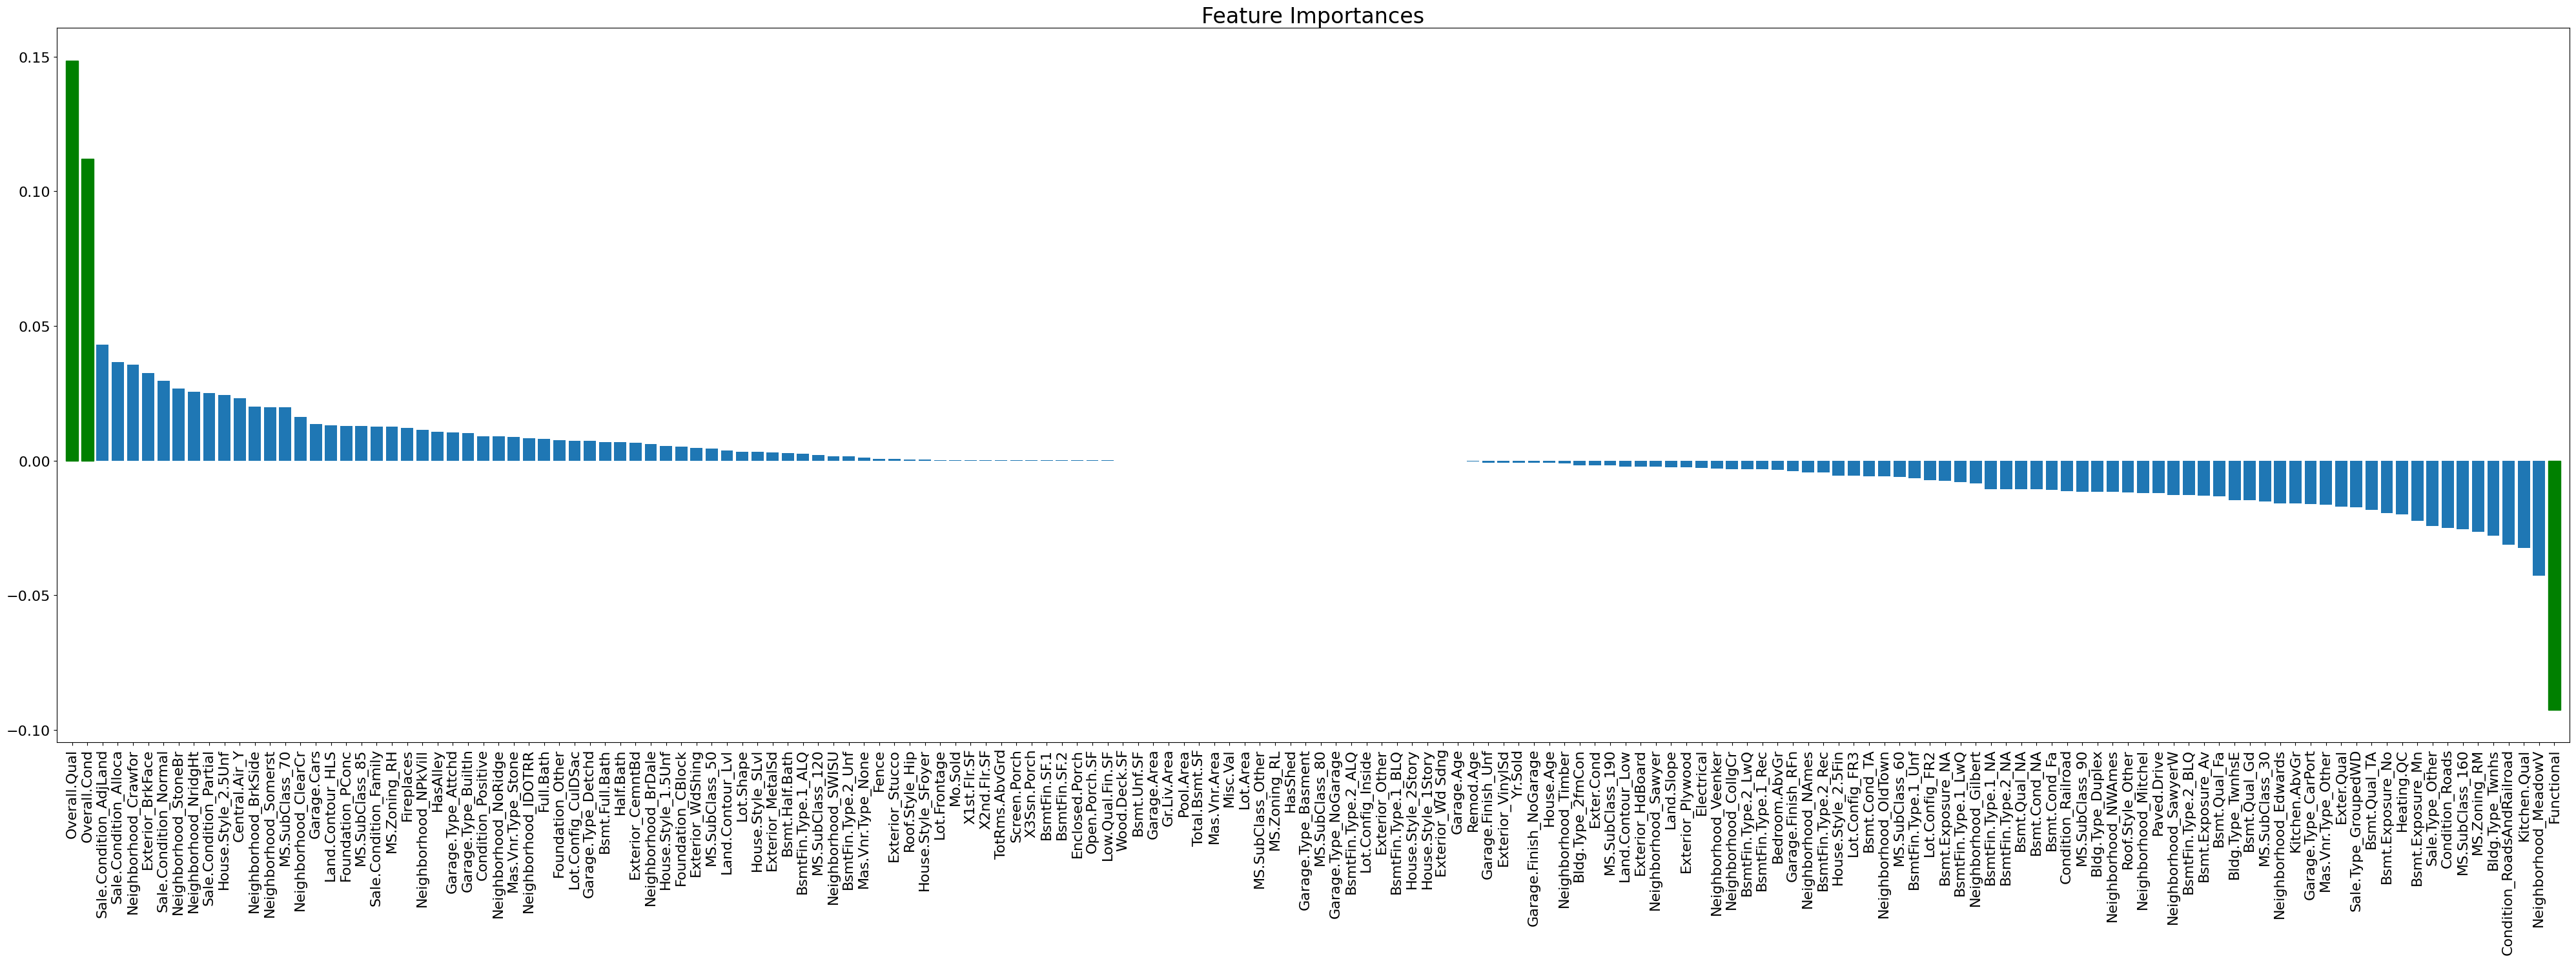

In [297]:
import matplotlib.pyplot as plt
# Get feature importances
best_model = sorted_results[1][1]['best_model']

# Get best model scores
print(f"Best model scores: {sorted_results[1][1]['best_score']}")
best_model_scores = sorted_results[1][1]['best_score']

# Get feature importances from best model
importances = best_model.coef_

# Get feature names from Xtrain
feature_names = model_data.drop(columns=['SalePrice']).copy().columns

# Sort features by importance in descending order
indices = importances.argsort()[::-1]

# Create a bar chart
plt.figure(figsize=(40, 15))
plt.title("Feature Importances", fontsize=24)  # Increase title fontsize
bars = plt.bar(range(Xtrain.shape[1]), importances[indices], align="center")

# Change color of bars with absolute values greater than 0.6
for i, bar in enumerate(bars):
    if abs(importances[indices][i]) > 0.05:
        bar.set_color('green')

plt.xticks(range(Xtrain.shape[1]), feature_names[indices], rotation=90, fontsize=16)  # Increase x-axis fontsize
plt.yticks(fontsize=16)  # Increase y-axis fontsize
plt.xlim([-1, Xtrain.shape[1]])
plt.tight_layout()
plt.show()



## What about combining models?

Ensemble methods combine the predictions of multiple machine learning models to improve overall predictive performance. In the case of StackingRegressor, it combines the outputs of multiple regression models to make more accurate predictions. We can combine both best models on the grid search above to create a stacked model.

In [298]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('ElasticNet', ElasticNet(**params['ElasticNet'])),
    ('DecisionTree', DecisionTreeRegressor(**params['DecisionTreeRegressor'])),
]

# Define the StackingRegressor
StackingRegressorModel = StackingRegressor(estimators=estimators,
                                           final_estimator=RandomForestRegressor(**params['RandomForestRegressor']))

# Train the model on training data
StackingRegressorModel.fit(X=Xtrain, y=ytrain)
StackingRegressorScore = -cross_val_score(StackingRegressorModel, Xtrain, ytrain, cv=10, scoring='neg_mean_squared_error')

# Get the mean error
meanError = 100*((10**(np.sqrt(np.mean(StackingRegressorScore))))-1)
print("StackingRegressor Results: ")
print(f"Mean Test Score %: {meanError}")

StackingRegressor Results: 
Mean Test Score %: 11.78364161675729


Woow! Looks like our model really improved by combining different models. Lets see if we can statistically prove that the difference is significant.

## Hypothesis testing: is the model really better?

In [299]:
# Cross val training Random Forest Model best model to get list of scores

#print model name

best_model.fit(X=Xtrain, y=ytrain)
RandomForestScore = -cross_val_score(best_model, Xtrain, ytrain, cv=10, scoring='neg_mean_squared_error')

# Get the mean error
meanError = 100*((10**(np.sqrt(np.mean(RandomForestScore))))-1)
print("RandomForst Results: ")
print(f"Mean Test Score %: {meanError}")

RandomForst Results: 
Mean Test Score %: 10.98259791044729


In [300]:
from scipy import stats

# Performance scores for StackingRegressor and Elastic Net
stacking_scores = StackingRegressorScore  # Replace with actual scores
random_forest_scores = RandomForestScore  # Replace with actual scores

# Calculate performance differences
differences = [random_forest-stacking for stacking, random_forest in zip(stacking_scores, random_forest_scores)]

# Perform a paired t-test
t_statistic, p_value = stats.ttest_rel(random_forest_scores,stacking_scores)

alpha = 0.05  # Set your significance level
print(p_value)
# Interpret the results
if p_value < alpha:
    print("There is a significant difference in performance between Stacking and Random Forest.")
else:
    print("There is no significant difference in performance between the models.")

1.725998545978009e-05
There is a significant difference in performance between Stacking and Random Forest.


## WE DID IT!

By combining models we created a new one that is significantly better than the previous ones.

# Testing the model on the test set

In [305]:
from sklearn.metrics import mean_squared_error

# Fit and transform the stacked model                             
best_model.fit(X=Xtrain, y=ytrain)

# Predict target values
y_pred = best_model.predict(Xtest)

# Get the mean error
mean_error = mean_squared_error(ytest, y_pred)

# Print mean error
mean_relative_error = 100*((10**(np.sqrt(mean_error)))-1)
print(f'Mean Absolute Error of {type(best_model).__name__}: {round(mean_relative_error, 2)}%')

Mean Absolute Error of ElasticNet: 12.03%


# Training the model on the whole dataset and saving it

In [306]:
import joblib
best_model.fit(X=X, y=y)

# Save the model and create the file if not exists
model_path = pathlib.Path.cwd().parent / 'models' / 'best_model.pkl'
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(model, model_path)

['/home/andre/Desktop/MachineLearning/ames_AndreVictor/models/stacking_model.pkl']